Before I code anything, I would like to present a short summmary. The main task was to create a machine learning model able to predict the price of a house based on different factors such as its number of bedrooms, living space area or the property condition. For this purpose I used Python as the programming language of my choice, together with typical machine learning libraries such as NumPy, pandas, matplotlib and sklearn. 

I started by importing the necessary libraries:

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

And getting the data from the provided csv file:

In [2]:
houses = pd.read_csv('house.csv')
houses.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [3]:
houses.shape

(21613, 21)

It appears that all the data has been loaded correctly - the dataset has 21613 rows, each corresponding to a given house, and 20 columns, each corresponding to a single feature of all the houses, e.g. the number of bedrooms. At this point the data is not really well organised, as several columns need to be changed or deleted. I began by simply reindexing the datase and taking a look at the data structure.

In [4]:
houses.set_index('id', inplace = True)

#turning off scientific notation
pd.options.display.float_format = '{:.2f}'.format

houses.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00
mean,540088.14,3.37,2.11,2079.90,15106.97,1.49,0.01,0.23,3.41,7.66,1788.39,291.51,1971.01,84.40,98077.94,47.56,-122.21,1986.55,12768.46
std,367127.20,0.93,0.77,918.44,41420.51,0.54,0.09,0.77,0.65,1.18,828.09,442.58,29.37,401.68,53.51,0.14,0.14,685.39,27304.18
min,75000.00,0.00,0.00,290.00,520.00,1.00,0.00,0.00,1.00,1.00,290.00,0.00,1900.00,0.00,98001.00,47.16,-122.52,399.00,651.00
25%,321950.00,3.00,1.75,1427.00,5040.00,1.00,0.00,0.00,3.00,7.00,1190.00,0.00,1951.00,0.00,98033.00,47.47,-122.33,1490.00,5100.00
50%,450000.00,3.00,2.25,1910.00,7618.00,1.50,0.00,0.00,3.00,7.00,1560.00,0.00,1975.00,0.00,98065.00,47.57,-122.23,1840.00,7620.00
75%,645000.00,4.00,2.50,2550.00,10688.00,2.00,0.00,0.00,4.00,8.00,2210.00,560.00,1997.00,0.00,98118.00,47.68,-122.12,2360.00,10083.00
max,7700000.00,33.00,8.00,13540.00,1651359.00,3.50,1.00,4.00,5.00,13.00,9410.00,4820.00,2015.00,2015.00,98199.00,47.78,-121.31,6210.00,871200.00


In [5]:
houses.isnull().values.any()

False

Fortunately there aren't any missing values in the dataset, although the "date" column needs some preparation for the future modelling. I will handle this in a moment. At first I would like to take a look on the histograms of all the numerical values from the data:

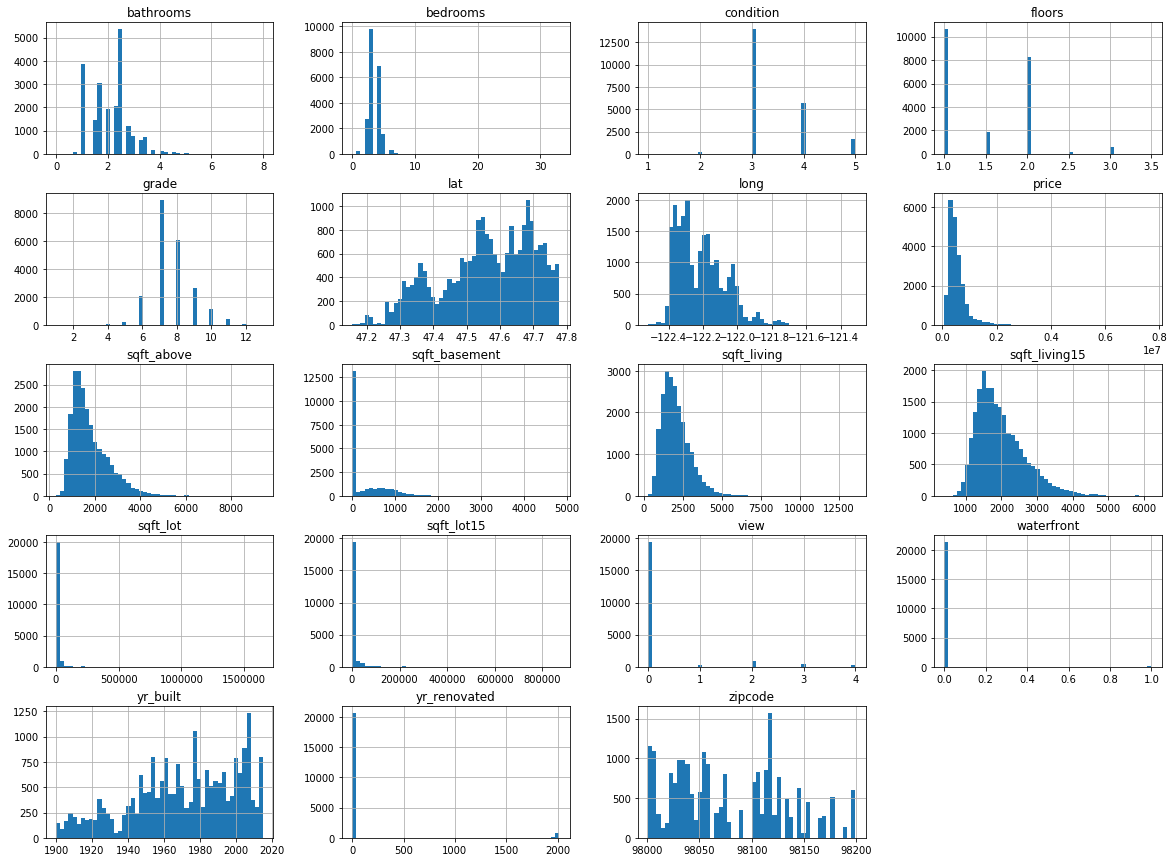

In [6]:
%matplotlib inline
houses.hist(bins=50, figsize = (20,15))
plt.show()

One can observe several things in the data structure: for example, the numbers of bathrooms are discrete values, but with spacing of 0.25, meaning the house might have 2.25 or 2.75 bathrooms - probably toilet alone does not count as the "full" bathroom. Many histograms are characterized by heavy-tailed distributions. Because of this some machine learning alghorithms might have problems with generalizing the data. Most of them also do not like when attributes' values are in different scales - like in this case. This is where min-max scalling will be useful. There are also features like zipcode that, even though they are numerical, do not make much sense in predicting the house price and will be ommited.

Coming back to the "date" column, I removed the 'T000000' part and converted the string to the pandas timestamp variable type:

In [7]:
houses['date'] = houses['date'].str.rstrip('T000000')
houses['date'] = pd.to_datetime(houses['date'], format='%Y%m%d', errors='ignore')
houses.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,,,,,,,,,,,,,,,,,,,,
7129300520,2014-10-13,221900.00,3,1.00,1180,5650,1.00,0,0,3,7,1180,0,1955,0,98178,47.51,-122.26,1340,5650
6414100192,2014-12-09,538000.00,3,2.25,2570,7242,2.00,0,0,3,7,2170,400,1951,1991,98125,47.72,-122.32,1690,7639
5631500400,2015-02-25,180000.00,2,1.00,770,10000,1.00,0,0,3,6,770,0,1933,0,98028,47.74,-122.23,2720,8062
2487200875,2014-12-09,604000.00,4,3.00,1960,5000,1.00,0,0,5,7,1050,910,1965,0,98136,47.52,-122.39,1360,5000
1954400510,2015-02-18,510000.00,3,2.00,1680,8080,1.00,0,0,3,8,1680,0,1987,0,98074,47.62,-122.05,1800,7503


In this task it does not matter if a particular day was Monday, Thursday or any other day. What might matter is the absolute time which passed from the pricing day to the day the prediction is made - because of inflation, a house worth \\$100000 in 2014 is probably worth more than \\$100,000 in 2015. Since the latest record from the data is from 27 V 2015 I chose 1 I 2016 as the reference date, thus changing the timestamp variable value to be strictly numerical. 

I also deleted the columns which will not be utilized according to the pdf file with instructions - although it might matter whether the house was renovated or not when predicting its price.

In [8]:
ref_day = pd.to_datetime('1-1-2016 00:00')
ref_year = 2016

houses = houses.drop(['yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15'], axis=1)

#converting pricing date to number of days
houses['days_passed']=(ref_day-houses['date']).dt.days
houses.drop(['date'], axis=1, inplace = True)

#converting year built to age 
#houses['age']=ref_year-houses['yr_built']
#houses.drop(['yr_built'], axis=1, inplace = True)

houses.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,days_passed
id,,,,,,,,,,,,,,
7129300520,221900.00,3,1.00,1180,5650,1.00,0,0,3,7,1180,0,1955,445
6414100192,538000.00,3,2.25,2570,7242,2.00,0,0,3,7,2170,400,1951,388
5631500400,180000.00,2,1.00,770,10000,1.00,0,0,3,6,770,0,1933,310
2487200875,604000.00,4,3.00,1960,5000,1.00,0,0,5,7,1050,910,1965,388
1954400510,510000.00,3,2.00,1680,8080,1.00,0,0,3,8,1680,0,1987,317


Before I make more plots and try to find some correlations, I am going to split the data into the training and test sets and work only on the training data. At this point it would be helpful to talk to the experts and ask what might be the most important feature when predicting the price - I would like my test set to truly represent the structure of the whole dataset in terms of this particular feature.

In [9]:
train_set, test_set = train_test_split(houses, test_size = 0.2, random_state = 42)
houses = train_set.copy()

Since the size of the dataset is not that big, one can compute Pearson correlation coefficient between each two features using the corr() method:

In [10]:
pd.options.display.float_format = '{:.4f}'.format
corr_matrix = houses.corr()
corr_matrix['price'].sort_values(ascending=False)

price            1.0000
sqft_living      0.7017
grade            0.6651
sqft_above       0.6033
bathrooms        0.5266
view             0.3921
sqft_basement    0.3214
bedrooms         0.3083
floors           0.2534
waterfront       0.2529
sqft_lot         0.0910
yr_built         0.0491
condition        0.0363
days_passed     -0.0034
Name: price, dtype: float64

As expected, the price of the house is highly correlated with its living space area and the property grade. I can now plot each of the numerical value with respect to every other numerical value, but because there are in total 14*//14 combinations of the attributes, I will focus only on the ones which seem to be the most important.

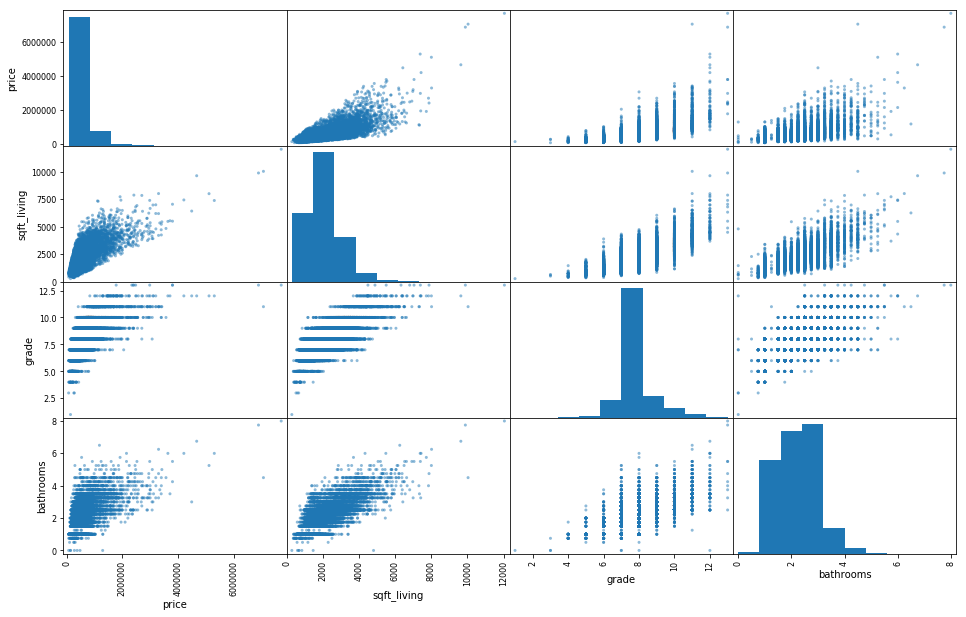

In [11]:
%matplotlib inline
attributes = ['price', 'sqft_living', 'grade', 'bathrooms']
scatter_matrix(houses[attributes], figsize=(16,10))
plt.show()

A correlation between those any of these two attributes is really strong - one can easily see upwards trends. Note that I did not include sqft_above attribute here, because it is highly dependant on sqft_living, which is already included.

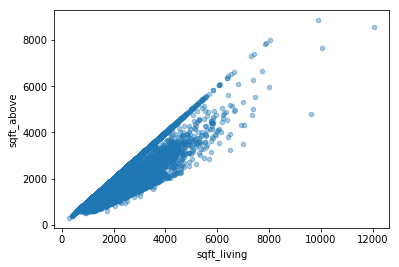

In [12]:
houses.plot(kind='scatter', x='sqft_living', y='sqft_above', alpha = 0.4)
plt.show()

A visible line indicates the cases where living area above grand level is equal to the whole living space area, so the houses without the ground level.

In [13]:
houses = train_set.drop('price', axis=1)
prices = train_set['price'].copy()

At this point the data is almost ready. The last part I decided to do is feature scalling, because most of machine learning algorithms do not work well with every attribute being in a different scale. For the normalization I used the MinMaxScaler function from scikit-learn:

In [18]:
houses = houses.astype(float)
scaler = StandardScaler()
houses_scaled = scaler.fit_transform(houses)

For the modelling part, I started by picking the most common machine learning model, linear regression:

In [19]:
lin_reg = LinearRegression()
lin_reg.fit(houses_scaled, prices)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

After fitting the model, it is possible to make some predictions based on the training set:

In [29]:
some_houses = houses_scaled[:5]
some_prices = prices[:5]
some_predictions = lin_reg.predict(some_houses)
labels = list(some_prices)
np.set_printoptions(precision=1)
print('Predictions: ', some_predictions)
print('Labels (real prices): ', list(some_prices))

Predictions:  [575651.4 286909.1 224152.3 451818.1 477096.1]
Labels (real prices):  [325000.0, 257000.0, 228500.0, 288000.0, 479000.0]


One can see that the model in fact works, although some of its predictions are far from the ground-truth. The relative difference between the first prediction and its label is almost 80%, despite others being really close. Defining model accuracy as the root-mean-square error one can calculate it for the whole training set:

In [38]:
predictions = lin_reg.predict(houses_scaled)
mse = mean_squared_error(predictions, prices)
rmse = np.sqrt(mse)
print("RMSE: {:.2f}".format(rmse))

RMSE: 212923.16
